# Continual learning: Overcoming catastophic forgetting with memory replay

In this exercise class we'll implement an experiment to measure catastrophic forgetting in a neural network trained on MNIST. We will then fix/reduce the catastrophic forgetting by implementing a simple memory replay strategy.

The following figure highlights the setup of the dataset and is taken from [van den Ven & Tolias, 2019](https://arxiv.org/pdf/1904.07734.pdf):

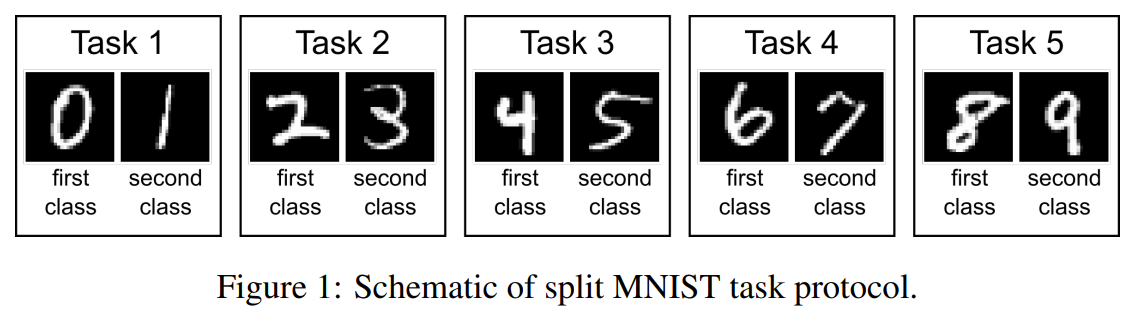

In [1]:
"""
Code adapted from the torchvision MNIST example:
https://github.com/pytorch/examples/blob/main/mnist/main.py

BSD 3-Clause License

Copyright (c) 2017, 
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
# Network implementation -- bonus exercise: Modify the network architecture,
# and study the effect on the training results.

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
# Exercise: Adapt the following function and store part of the images
# presented during training in a replay buffer. Replay these images
# during the training step.

def train(args, model, device, train_loader, optimizer, epoch, buffer = None):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        ### START SOLUTION ###
        # We append images and labels from the first training batch
        # to our buffer. You can extend this strategy based on how
        # many images you choose to store in the buffer.
        if buffer is not None and batch_idx == 0:
            if buffer is not None:
                images, targets = next(iter(train_loader))
                buffer.add(images, targets)
        ### END SOLUTION ###


        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        ### START SOLUTION ###
        # A simple strategy for overcoming forgetting is to retrieve images
        # from the buffer (here: one image per class) and perform a gradient
        # step on these images along with every incoming new batch.
        if buffer is not None and len(buffer) > 0:
            replayed_images, replayed_targets = buffer.get()
            replayed_images = replayed_images.to(device)
            replayed_targets = replayed_targets.to(device)
            optimizer.zero_grad()
            output = model(replayed_images)
            loss = F.nll_loss(output, replayed_targets)
            loss.backward()
            optimizer.step()
        ### END SOLUTION ###

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

In [4]:
# The test routine was adapted from the original implementation and now computes
# the classification probabilities per class instead of an average. This allows to
# later assess the effect of catastrophic forgetting. No adaptations in this function
# are required for the exercise.

import collections

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct_by_class = collections.Counter()
    count_by_class = collections.Counter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float()
            for class_ in range(10):
                idc = (target == class_)
                correct_by_class[class_] += correct[idc].sum().item()
                count_by_class[class_] += idc.sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}')
    result = {}
    for class_ in range(10):
        acc = correct_by_class[class_] / count_by_class[class_]
        result[class_] = acc
        print(
            f"Class {class_} accuracy: "
            f"{correct_by_class[class_]}/{count_by_class[class_]}"
            f"({acc*100:.0f}%)"
        )

    return result

In [5]:
# Exercise: Adapt the dataset class "MNISTContinualLearning" for the experiment
# outlined in the introduction text. The class needs to support indexing of the
# dataset based on the provided list of classes.

def identity(x):
  return

class MNISTContinualLearning(datasets.MNIST):

  def __init__(self, *args, classes=list(range(10)), **kwargs):

    # This inherits from the base dataset
    super().__init__(*args, **kwargs)

    if len(classes) < 2:
      raise ValueError(f"Need at least two classes, but got {len(classes)}")

    # Add code for filtering the dataset here. You need to adapt
    # the "data" and "targets" attribute of the dataset. The "data"
    # attribute stores the images as a numpy array, while the "targets"
    # attributes stores the labels as a numpy array.
    # You can override the existing attributes.
    #
    # self.data = ...
    # self.targets = ...
    
    ### START SOLUTION ###
    idc = None
    for class_ in classes:
      if idc is None:
        idc = self.targets == class_
      idc |= self.targets == class_

    self.data    = self.data[idc]
    self.targets = self.targets[idc]
    ### END SOLUTION ###


def test_dataset():
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = MNISTContinualLearning('../data', train=True, download=True, transform=transform, classes = [0, 5])
    assert len(dataset1) == 11344

test_dataset()

In [6]:
# To implement memory replay, add additional code (functions or classes)
# to this cell. One possible solution is to implement a "Buffer" class
# that allows to add images into memory, and allows to retrieve the stored
# images and labels for training the model.
#
# The buffer is typically memory constrained, and there are multiple ways
# to efficiently compress the individual elements present in the buffer.
# Think about different ways of reducing the storage required by your buffer
# class, and explore which of them is most effective at mitigating catastophic
# forgetting.


### START SOLUTION ###

class Buffer(nn.Module):

    def __init__(self):
        self.buffer = {}
    
    def add(self, images, targets):
        for class_ in targets.unique():
            idc = targets == class_
            self.buffer[class_] = images[idc][0]

    def get(self):
        assert len(self) > 0
        keys = list(self.buffer.keys())
        targets = torch.tensor(keys)
        images = torch.stack([self.buffer[k] for k in keys], dim = 0)
        assert len(targets) == len(images)
        return images, targets

    def __len__(self):
        return sum(len(v) if v is not None else 0 for v in self.buffer.values())
      
### END SOLUTION ###

In [7]:
# Adapt the main training loop to work with the functions you defined above.

def train_model(args, model, phase, replay_buffer = [], history = [], buffer = None):
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    torch.manual_seed(args.seed)

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    # You need to replace the original MNIST dataset here by the continual
    # learning dataset we implemented in the previous cell. Make sure to
    # pass the list of classes selected for training in args.train_classes.
    
    ### START SOLUTION ###
    # We added the revised MNIST class here, which takes the same arguments
    # as the original class, but additionally takes a "classes" argument which
    # specifies the subselection of classes to consider during this training
    # phase.
    dataset1 = MNISTContinualLearning('../data', train=True, download=True,
                       transform=transform, classes=args.train_classes)
    ### END SOLUTION ###
    dataset2 = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = model.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    for epoch in range(1, args.epochs + 1):
        ### START SOLUTION ###
        # We additionally pass the "buffer" class here to collect training
        # images for later memory replay.
        # 
        # Original content:
        # train(args, model, device, train_loader, optimizer, epoch)
        train(args, model, device, train_loader, optimizer, epoch, buffer)
        ### END SOLUTION ###
        test_results = test(model, device, test_loader)
        test_results["phase"] = phase
        history.append(test_results)
        scheduler.step()

    return history


In [18]:
# We now define the experiment setup.
# Without modifications to the code, the following will simply train an MNIST
# network multiple times, and reach an accuracy of >99% on the test set.
#
# The result will be modified in two steps:
#
# -- first, after implementing the MNISTContinualLearning dataset, you will be
#    able to observe catastrophic forgetting: Training on a new task (specified)
#    by the "phase" and "config.train_classes" variables will make the network
#    forget the previously learned tasks, and you will observe a performance drop.
#
# -- second, after implementing the catastrophic forgetting network, you will
#    fix the catastrophic forgetting my implementing a simple memory buffer. This
#    buffer will keep some of the images seen in each individual training phase,
#    and add them to the training in each subsequent phase. This task is open-ended
#    and different strategies exist. They will differ in terms of memory efficiency
#    and performance.

# You should adapt the train config to each experiment setup and especially test the
# effects of taking different values for the number of epochs (per phase of the training)
# and the learning rate used.
config = argparse.Namespace(
    batch_size=64, 
    test_batch_size=1000, 
    epochs=3, 
    lr=0.01,
    gamma=0.7,
    no_cuda=False,
    dry_run=False,
    seed=1,
    log_interval=10,
    save_model=False
)

def train_regular_mnist():
    model = Net()
    history = []

    config.train_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train_model(config, model, phase = "baseline", history = history)
    return history

# Uncomment to train
#history_regular_mnist = train_regular_mnist()
#history_regular_mnist

In [19]:
# Exercise 1: Implement an experiment setup that measures catastrophic forgetting while
# training in a task-incremental way on digits (0,1), (2,3), ..., (8, 9). After finishing
# training, measure the performance on the first task again.
#
# Implementation requires to fill in code further up in this notebook. You can visualize
# the result using the code further below.

### START SOLUTION ###
# In this first part, we implement an experiment setup to measure catastrophic forgetting.
# We will subsequently train on pairs of classes, (0,1), then (2,3), etc., and in the end
# revisit the first task to measure if there was any forward transfer while training on the
# other tasks.

def train_catastrophic_forgetting():
    model = Net()
    history = []

    config.train_classes = [0, 1]
    train_model(config, model, phase = "0_1", history = history)
  
    config.train_classes = [2, 3]
    train_model(config, model, phase = "2_3", history = history)

    config.train_classes = [4, 5]
    train_model(config, model, phase = "4_5", history = history)

    config.train_classes = [6, 7]
    train_model(config, model, phase = "6_7", history = history)

    config.train_classes = [8, 9]
    train_model(config, model, phase = "8_9", history = history)
    
    config.train_classes = [0, 1]
    train_model(config, model, phase = "0_1_again", history = history)

    return history

### END SOLUTION ###
    
history_catastrophic_forgetting = train_catastrophic_forgetting()
history_catastrophic_forgetting

Train Epoch: 1 [0/12665 (0%)]	Loss: 2.295613
Train Epoch: 1 [640/12665 (5%)]	Loss: 1.647854
Train Epoch: 1 [1280/12665 (10%)]	Loss: 1.039609
Train Epoch: 1 [1920/12665 (15%)]	Loss: 0.593714
Train Epoch: 1 [2560/12665 (20%)]	Loss: 0.321345
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.211062
Train Epoch: 1 [3840/12665 (30%)]	Loss: 0.124204
Train Epoch: 1 [4480/12665 (35%)]	Loss: 0.082856
Train Epoch: 1 [5120/12665 (40%)]	Loss: 0.075962
Train Epoch: 1 [5760/12665 (45%)]	Loss: 0.071156
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.117059
Train Epoch: 1 [7040/12665 (56%)]	Loss: 0.059726
Train Epoch: 1 [7680/12665 (61%)]	Loss: 0.032035
Train Epoch: 1 [8320/12665 (66%)]	Loss: 0.033078
Train Epoch: 1 [8960/12665 (71%)]	Loss: 0.030728
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.039060
Train Epoch: 1 [10240/12665 (81%)]	Loss: 0.035301
Train Epoch: 1 [10880/12665 (86%)]	Loss: 0.041941
Train Epoch: 1 [11520/12665 (91%)]	Loss: 0.040506
Train Epoch: 1 [12160/12665 (96%)]	Loss: 0.014235

Test set: Average los

[{0: 0.996938775510204,
  1: 0.9991189427312775,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.996938775510204,
  1: 0.9991189427312775,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.996938775510204,
  1: 0.9991189427312775,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.0,
  1: 0.0,
  2: 0.9612403100775194,
  3: 0.9772277227722772,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.0,
  1: 0.0,
  2: 0.9670542635658915,
  3: 0.9841584158415841,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.0,
  1: 0.0,
  2: 0.9757751937984496,
  3: 0.9752475247524752,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.994908350305499,
  5: 0.9708520179372198,
  6: 0.0,
  7: 0.0,


In [20]:
# Exercise 2: Implementing the previous exercise should have shown that the network
# suffers from catastrophic forgetting. To fix this, implement a memory replay buffer
# and use this buffer to counteract the catastrophic forgetting.
#
# Implementation requires adaptation of the cells above, plus the addition of a new
# experiment setup below.


### START SOLUTION ###
# The experiment setup is identical to the one above, but now we initialize and use
# a replay buffer. Right now, the buffer only stores a single image for each class.
# As a bonus exercise, explore how different variants of the replay buffer affect the
# resulting model performance.

def train_memory_replay():
    model = Net()
    history = []
    buffer = Buffer()

    config.train_classes = [0, 1]
    train_model(config, model, phase = "0_1", history = history, buffer = buffer)
  
    config.train_classes = [2, 3]
    train_model(config, model, phase = "2_3", history = history, buffer = buffer)

    config.train_classes = [4, 5]
    train_model(config, model, phase = "4_5", history = history, buffer = buffer)

    config.train_classes = [6, 7]
    train_model(config, model, phase = "6_7", history = history, buffer = buffer)

    config.train_classes = [8, 9]
    train_model(config, model, phase = "8_9", history = history, buffer = buffer)
    
    config.train_classes = [0, 1]
    train_model(config, model, phase = "0_1_again", history = history, buffer = buffer)

    return history

### END SOLUTION ###

history_memory_replay = train_memory_replay()
history_memory_replay

Train Epoch: 1 [0/12665 (0%)]	Loss: 2.196357
Train Epoch: 1 [640/12665 (5%)]	Loss: 1.335955
Train Epoch: 1 [1280/12665 (10%)]	Loss: 0.555878
Train Epoch: 1 [1920/12665 (15%)]	Loss: 0.146986
Train Epoch: 1 [2560/12665 (20%)]	Loss: 0.082966
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.054255
Train Epoch: 1 [3840/12665 (30%)]	Loss: 0.011100
Train Epoch: 1 [4480/12665 (35%)]	Loss: 0.078007
Train Epoch: 1 [5120/12665 (40%)]	Loss: 0.005687
Train Epoch: 1 [5760/12665 (45%)]	Loss: 0.004260
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.002415
Train Epoch: 1 [7040/12665 (56%)]	Loss: 0.005845
Train Epoch: 1 [7680/12665 (61%)]	Loss: 0.005518
Train Epoch: 1 [8320/12665 (66%)]	Loss: 0.001475
Train Epoch: 1 [8960/12665 (71%)]	Loss: 0.002208
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.000701
Train Epoch: 1 [10240/12665 (81%)]	Loss: 0.000352
Train Epoch: 1 [10880/12665 (86%)]	Loss: 0.000833
Train Epoch: 1 [11520/12665 (91%)]	Loss: 0.002580
Train Epoch: 1 [12160/12665 (96%)]	Loss: 0.002562

Test set: Average los

[{0: 0.9959183673469387,
  1: 0.9991189427312775,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.9959183673469387,
  1: 1.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.996938775510204,
  1: 1.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '0_1'},
 {0: 0.8459183673469388,
  1: 0.9215859030837005,
  2: 0.9602713178294574,
  3: 0.9732673267326732,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.7795918367346939,
  1: 0.8801762114537445,
  2: 0.9689922480620154,
  3: 0.9782178217821782,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.7377551020408163,
  1: 0.852863436123348,
  2: 0.9680232558139535,
  3: 0.9821782178217822,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  'phase': '2_3'},
 {0: 0.7755102040816326,
  1: 0.8687224669603524

# Analysis of the results

In [11]:
# The following helper code takes the logs and converts them into a dataframe
# for easier reading. You can also store the result as a CSV or HDF file by
# using the .to_csv and .to_hdf methods from pandas for later reading.

import matplotlib.pyplot as plt
import pandas as pd

def format_results(history):
    logs = pd.DataFrame(history).round(2)
    logs.index.name = 'epoch'
    logs = logs.reset_index(drop = False)
    return logs

#display(format_results(history_regular_mnist).head())
display(format_results(history_catastrophic_forgetting).head())
display(format_results(history_memory_replay).head())

,epoch,0,1,2,3,4,5,6,7,8,9,phase
0,0,0.96,0.97,0.82,0.85,0.59,0.35,0.86,0.85,0.52,0.82,baseline


,epoch,0,1,2,3,4,5,6,7,8,9,phase
0,0,1.0,1.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0_1
1,1,0.0,0.0,0.14,1.0,0.00,0.00,0.0,0.00,0.0,0.00,2_3
2,2,0.0,0.0,0.00,0.0,0.99,0.89,0.0,0.00,0.0,0.00,4_5
3,3,0.0,0.0,0.00,0.0,0.00,0.00,1.0,0.93,0.0,0.00,6_7
4,4,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,1.0,0.52,8_9


,epoch,0,1,2,3,4,5,6,7,8,9,phase
0,0,1.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0_1
1,1,0.04,0.51,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2_3
2,2,0.71,0.64,0.06,0.00,0.98,0.85,0.00,0.00,0.00,0.00,4_5
3,3,0.23,0.53,0.00,0.01,0.00,0.00,0.99,0.96,0.00,0.00,6_7
4,4,0.44,0.55,0.00,0.00,0.00,0.00,0.19,0.00,0.98,0.88,8_9


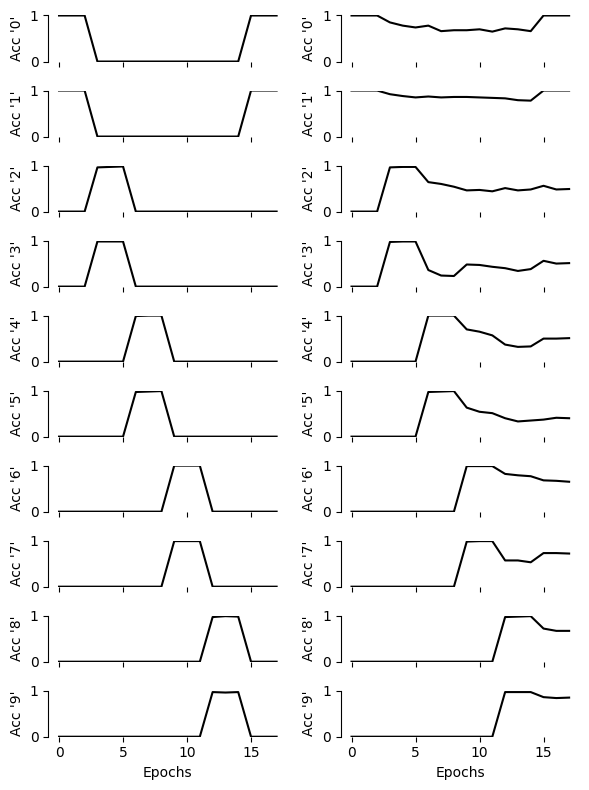

In [25]:
# Finally, we plot the results and optionally compare the three different training setups.
# Try to adapt and extend the plotting function to the needs of your experimental setup.

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(10, 2, figsize = (6, 8), sharex = True)

# Iterate over the different training setups for comparison
for log_id, logs in enumerate([history_catastrophic_forgetting, history_memory_replay]):
    # Format the logs into a dataframe
    logs = format_results(logs)

    # Iterate through the 10 different MNIST classes (0...9). We will plot one subpanel
    # for each of them, showing the accuracies for that particular class over the course
    # of the entire training.
    for class_ in range(10):
        # Get the correct subpanel of the plot
        ax = axes[class_, log_id]
        
        # Draw a line plot: The x axis will be the epoch, the y axis will be the accuarcy
        # for predicting a particular class.
        ax.plot(logs.epoch, logs[class_], color = 'black')
        
        # Finally, we will optimize the plot a bit and remove unneeded lines
        ax.set_ylim([0, 1])
        ax.set_ylabel(f"Acc '{class_}'")
        sns.despine(bottom = True, trim = True)

    ax.set_xlabel("Epochs")
plt.tight_layout()
plt.show()